In [1]:
from Unet_segment import *
from classification import *

import matplotlib.pyplot as plt
import numpy as np
import torch
import os

Using cpu device


## Loading single models

In [2]:
model1 = UNet()
model2 = UNet()

model_dir = 'trained_models'
# loading model weights and training progress metrics
model1_par = torch.load(os.path.join(model_dir, 'single_model1.pth') )
model2_par = torch.load(os.path.join(model_dir, 'single_model2.pth') )

# setting the parameters of the blank models
model1.load_state_dict(model1_par['model_state_dict'])
model2.load_state_dict(model2_par['model_state_dict'])
model1.eval()
model2.eval()

UNet(
  (downs): ModuleList(
    (0): Resblock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
      (identity_transform): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Resblock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

### Train loss

In [10]:
fig_dir = 'figures'
# if the directory does not exist yet, creates a new one 
if not os.path.exists(fig_dir):
    print("\\"+ fig_dir,'directory created')
    os.makedirs(fig_dir)

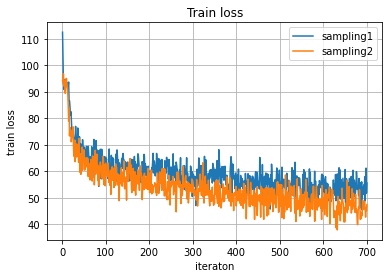

In [4]:
epoch_array = np.arange(1,len(model1_par['train_loss'])+1)

plt.figure()

plt.plot(epoch_array, model1_par['train_loss'], label='sampling1')
plt.plot(epoch_array, model2_par['train_loss'], label='sampling2')
plt.xlabel('iteraton')
plt.ylabel('soft dice coefficent')
plt.legend()
plt.grid()
plt.title('Train loss')

plt.savefig(os.path.join(fig_dir,'train_loss.png'))

### Test loss

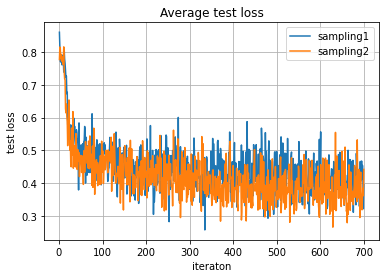

In [5]:
plt.figure()

plt.plot(epoch_array, model1_par['test_loss'], label='sampling1')
plt.plot(epoch_array, model2_par['test_loss'], label='sampling2')
plt.xlabel('iteraton')
plt.ylabel('test loss')
plt.legend()
plt.grid()
plt.title('Average test loss')

plt.savefig(os.path.join(fig_dir,'test_loss.png'))

### Jaccard's metric

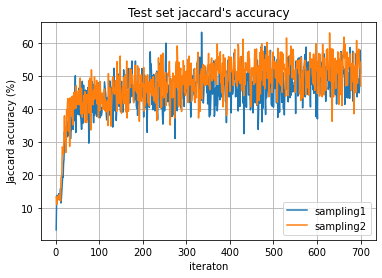

In [6]:
plt.figure()

plt.plot(epoch_array, model1_par['jaccard_accuracy'], label='sampling1')
plt.plot(epoch_array, model2_par['jaccard_accuracy'], label='sampling2')
plt.xlabel('iteraton')
plt.ylabel('Jaccard accuracy (%)')
plt.legend()
plt.grid()
plt.title("Test set jaccard's accuracy")
plt.savefig(os.path.join(fig_dir,'Jaccards accuracy.png'))

## Evaluating the performance on a validation set

In [7]:
acu_val1, los_val1 = validate(model1, val_loader, loss_dice)
acu_val2, los_val2 = validate(model2, val_loader, loss_dice)

In [11]:
avg_acu_val1 = torch.mean(acu_val1)
avg_acu_val2 = torch.mean(acu_val2)
std_acu_val1 = torch.std(acu_val1)
std_acu_val2 = torch.std(acu_val2)
avg_los_val1 = torch.mean(los_val1)
avg_los_val2 = torch.mean(los_val2)
std_los_val1 = torch.std(los_val1)
std_los_val2 = torch.std(los_val2)

In [15]:
print('Model with sampling1')
print('Jaccards accuracy: ({:0.2f} +/- {:0.2f})%'.format( float(avg_acu_val1*100), float(100*std_acu_val1) ))
print('Average loss     : {:0.2f} +/- {:0.2f}\n'.format(float(avg_los_val1), float(std_los_val1)))
print('Model trained with sampling2')
print('Jaccards accuracy: ({:0.2f} +/- {:0.2f})%'.format( float(avg_acu_val2*100), float(100*std_acu_val2) ))
print('Average loss     : {:0.2f} +/- {:0.2f}'.format(float(avg_los_val2), float(std_los_val2)))

Model with sampling1
Jaccards accuracy: (46.58 +/- 33.50)%
Average loss     : 0.45 +/- 0.37

Model trained with sampling2
Jaccards accuracy: (47.61 +/- 34.20)%
Average loss     : 0.44 +/- 0.38


In [17]:
# best segmentations
print(max(acu_val1))
print(max(acu_val2))

tensor(0.9322)
tensor(0.9427)


## Bland-Altman comparison

In [16]:
area_dif1, avg_area1 = bland_altman(model1,val_loader)
area_dif2, avg_area2 = bland_altman(model2,val_loader)

In [18]:
avg_dif1 = torch.mean(area_dif1)
avg_dif2 = torch.mean(area_dif2)
std_dif1 = torch.std(area_dif1)
std_dif2 = torch.std(area_dif2)
print(avg_dif1)
print(avg_dif2)

tensor(76.5154)
tensor(72.5853)


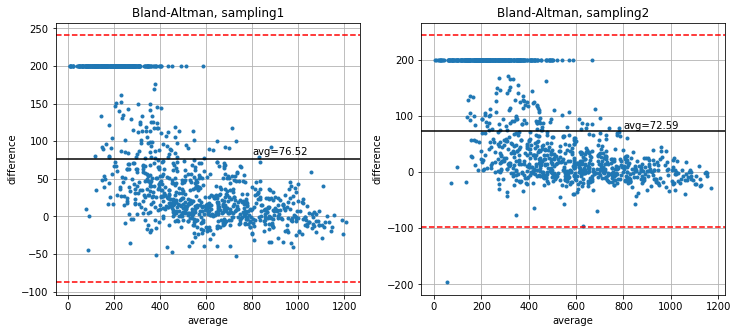

In [19]:
plt.figure(figsize=(12, 5) )

plt.subplot(1,2,1)
plt.plot(avg_area1, area_dif1,'.')
plt.axhline(y = avg_dif1, color = 'black')
plt.axhline(y = avg_dif1+1.96*std_dif1, color = 'r', linestyle = '--')
plt.axhline(y = avg_dif1-1.96*std_dif1, color = 'r', linestyle = '--')
plt.title('Bland-Altman, sampling1')
plt.text(800,avg_dif1+5,'avg={:0.2f}'.format(avg_dif1))
plt.grid()
plt.xlabel('average')
plt.ylabel('difference')

plt.subplot(1,2,2)
plt.plot(avg_area2, area_dif2, '.')
plt.axhline(y = avg_dif2, color = 'black') # mean
plt.axhline(y = avg_dif2+1.96*std_dif2, color = 'r', linestyle = '--') #
plt.axhline(y = avg_dif2-1.96*std_dif2, color = 'r', linestyle = '--') # 1.96 std
plt.title('Bland-Altman, sampling2')
plt.text(800,avg_dif2+5,'avg={:0.2f}'.format(avg_dif2))
plt.grid()
plt.xlabel('average')
plt.ylabel('difference')

plt.savefig(os.path.join(fig_dir,'Bland_altman.png'))

### Testing ensemble models 
redundant section due to untrained ensemble models

In [ ]:
# lists that will store the models
models_spl1 = nn.ModuleList()
models_spl2 = nn.ModuleList()

# creating the models, they only differ by number of downsamplings 2 and 3 
# 
for i in range(3):
    models_spl1.append(UNet())
    models_spl2.append(UNet())

# adding an extra downsampling level with 512 features
for i in range(2):
    models_spl1.append(UNet(features = [64, 128, 256, 512]))
    models_spl2.append(UNet(features = [64, 128, 256, 512]))

In [ ]:
ensemble_weights1 = torch.load(os.path.join(model_dir, 'ensemble_model1.pth') )
ensemble_weights2 = torch.load(os.path.join(model_dir, 'ensemble_model2.pth') )

step = 0
for key in ensemble_weights1:
    models_spl1[step].load_state_dict(ensemble_weights1[key])
    models_spl1[step].eval()
    step +=1
step =0
for key in ensemble_weights2:
    models_spl2[step].load_state_dict(ensemble_weights2[key])
    models_spl2[step].eval()
    step +=1

In [ ]:
def ensemble_validate(model_list, val_loader):
    jacc_array = torch.zeros(len(val_loader.dataset))
    #print(len(val_loader.dataset))
    for idx, (X,y) in enumerate(val_loader):
        y_preds = [model_list[i](X) for i in range(len(model_list)) ] # 5 predictions
        y_pred_avg = torch.zeros(y.shape)
        for pred in y_preds:
            y_pred_avg += pred
        
        jacc_array[idx] = jaccard(y_pred_avg/len(y_preds), y)
        
    #print('array of jaccards', jacc_array)
    return torch.mean(jacc_array)

In [ ]:
print(ensemble_validate(models_spl1, val_loader))

### Classification model

In [3]:
model_class_par = torch.load(os.path.join(model_dir, 'densenet121.pth') )
#print(densenet121)
densenet121.load_state_dict(model_class_par['model_state_dict'])
densenet121.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [14]:
acu_val_class, loss_cal_class = validate(densenet121, val_loader_cl, bce_loss, classify= True)

In [16]:
print('Accurately classified: {:0.2f}'.format(float(torch.mean(acu_val_class))*100),'%')
print(len(acu_val_class))

Accurately classified: 73.46 %
1070


## Composed classification-segmentation model

In [7]:
jac_acu_com1 , losses_com1 = validate_composed(densenet121, model1, val_loader_cl, val_set, loss_dice)
jac_acu_com2 , losses_com2 = validate_composed(densenet121, model2, val_loader_cl, val_set, loss_dice)

treshold 0.5
jac_array [tensor(0.), tensor(0.), tensor(0.7619), tensor(0.6256), tensor(0.5938), tensor(0.7795), tensor(0.8670), tensor(0.8359), tensor(0.9308), tensor(0.9054), tensor(0.9094), tensor(0.9286), tensor(0.8220), tensor(0.8122), tensor(0.6901), tensor(0.5805), tensor(0.7046), tensor(0.7893), tensor(0.8571), tensor(0.8893), tensor(0.8698), tensor(0.8757), tensor(0.9046), tensor(0.8986), tensor(0.5652), tensor(0.5391), tensor(0.8290), tensor(0.4286), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.4712), tensor(0.6898), tensor(0.8151), tensor(0.6903), tensor(0.5721), tensor(0.4283), tensor(0.3787), tensor(0.5032), tensor(0.1732), tensor(0.2614), tensor(0.1364), tensor(0.2063), tensor(0.2043), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.6018), tensor(0.8756), tensor(0.8074), tensor(0.8419), tensor(0.8574), tensor(0.8774), tensor(0.8606), tensor(0.8203), tensor(0.7706), tensor(0.8086), tensor(0.7472), tensor(0.7362), tensor(0.7689), tensor(0.693

jac_array [tensor(0.), tensor(0.), tensor(0.6083), tensor(0.6968), tensor(0.5771), tensor(0.7589), tensor(0.8468), tensor(0.8504), tensor(0.9039), tensor(0.8732), tensor(0.8611), tensor(0.8662), tensor(0.7349), tensor(0.7500), tensor(0.6917), tensor(0.7381), tensor(0.7900), tensor(0.7683), tensor(0.8403), tensor(0.8482), tensor(0.9024), tensor(0.8602), tensor(0.8835), tensor(0.8578), tensor(0.5620), tensor(0.6309), tensor(0.8404), tensor(0.3318), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.3922), tensor(0.6931), tensor(0.7347), tensor(0.6626), tensor(0.6027), tensor(0.4557), tensor(0.2435), tensor(0.2742), tensor(0.2754), tensor(0.2190), tensor(0.1290), tensor(0.2000), tensor(0.1542), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.7848), tensor(0.8511), tensor(0.8008), tensor(0.9273), tensor(0.8650), tensor(0.8588), tensor(0.8523), tensor(0.8534), tensor(0.7692), tensor(0.8233), tensor(0.7773), tensor(0.7822), tensor(0.7524), tensor(0.6477), tensor(0.

In [9]:
print('Jaccards accuracy: ({:0.3f}+/-{:0.3f})%'.format(np.mean(jac_acu_com1)*100, np.std(jac_acu_com1)*100))
print('average loss     : {:0.3f}+/-{:0.3f}\n'.format(torch.mean(torch.tensor(losses_com1)), torch.std(torch.tensor(losses_com1))))
print('Number of samples:', len(jac_acu_com1))

Jaccards accuracy: (47.313+/-33.233)%
average loss     : 0.441+/-0.369

Number of samples: 1052


In [8]:
print('Jaccards accuracy: ({:0.3f}+/-{:0.3f})%'.format(np.mean(jac_acu_com2)*100, np.std(jac_acu_com2)*100))
print('average loss     : {:0.3f}+/-{:0.3f}\n'.format(torch.mean(torch.tensor(losses_com2)), torch.std(torch.tensor(losses_com2))))
print('Number of samples:', len(jac_acu_com2))

Jaccards accuracy: (48.353+/-33.924)%
average loss     : 0.434+/-0.375

Number of samples: 1052


### Testing the treshold probability

In [4]:
tresholds = np.arange(55,85,3)/100
metrics_tresh1 = [0 for i in range(len(tresholds))]
metrics_tresh2 = [0 for i in range(len(tresholds))]
print(metrics_tresh1)
print(tresholds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.55 0.58 0.61 0.64 0.67 0.7  0.73 0.76 0.79 0.82]


In [5]:
def finding_treshold(model, metrics):
    for i, treshold in enumerate(tresholds):
        jac_tresh, losses = validate_composed(densenet121, model, val_loader_cl, val_set, loss_dice, treshold = treshold)

        metrics[i] = [np.mean(jac_tresh), 
                     np.std(jac_tresh),
                     torch.mean(torch.tensor(losses)),
                     torch.std(torch.tensor(losses))
                     ]
        
finding_treshold(model1, metrics_tresh1)
#finding_treshold(model2, metrics_tresh2)

In [6]:
print(metrics_tresh1)
#print(metrics_tresh2)

[[0.47950584, 0.3304763, tensor(0.4338), tensor(0.3663)], [0.48489735, 0.32873523, tensor(0.4277), tensor(0.3639)], [0.49660164, 0.32485712, tensor(0.4143), tensor(0.3581)], [0.50584877, 0.3221844, tensor(0.4043), tensor(0.3546)], [0.52478784, 0.31437972, tensor(0.3828), tensor(0.3435)], [0.5481934, 0.3040705, tensor(0.3569), tensor(0.3297)], [0.57089686, 0.2925759, tensor(0.3321), tensor(0.3141)], [0.6003504, 0.2724938, tensor(0.2990), tensor(0.2871)], [0.621339, 0.25599417, tensor(0.2758), tensor(0.2644)], [0.64103854, 0.23795909, tensor(0.2539), tensor(0.2391)]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[0.47950584 0.48489735 0.49660164 0.50584877 0.52478784 0.5481934
 0.57089686 0.6003504  0.621339   0.64103854]


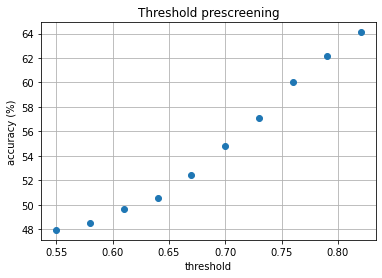

In [17]:
plt.figure()
print(np.array(metrics_tresh1)[:,0])
plt.plot(tresholds, np.array(metrics_tresh1)[:,0]*100, 'o')
#plt.plot(tresholds, np.array(metrics_tresh2)[:,0]*100, 'o')
plt.xlabel('threshold')
plt.ylabel('accuracy (%)')
plt.title('Threshold prescreening')
plt.grid()
plt.savefig(os.path.join(fig_dir,'prescreening.png'))